## Workshop Final: Título del trabajo

### Hacer el índice

En primera instancia, se cargarán todas las bibliotecas a utilizar. Algunas de ellas no se encuentran en el ambiente o requieren ser actualizadas, es por ello que dejamos las siguientes líneas comentadas para que se instalen las mismas

In [1]:
!pip install --upgrade pandas --user

In [2]:
!pip install --upgrade pandas-datareader --user

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [4]:
def evaluacion (activo,start,pred_size,lags):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval="m")
    df = df[["Close","Volume"]]
    
    df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
    df['log_value'] = np.log(df['Close'])
    df["sqrt"] = np.sqrt(df["Close"])
    df['month'] = [d.strftime('%b') for d in df.index]
    dummies_mes = pd.get_dummies(df['month'],drop_first=True)
    df = df.join(dummies_mes)
    
    df_train, df_test = train_test_split(df, test_size=pred_size, random_state=42, shuffle=False)
    
    model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()
    
    df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


    df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
    
    df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
    df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])
    res_model = df_train['Close'] - df_train['back_model_log_est']
    res_log_est = df_train['log_value'] - df_train['model_log_est']
    result = adfuller(res_model)
    result1 = adfuller(res_log_est)
    if result[1]<0.05:
        print("elegimos el residuo del precio de cierre - exp(log est) - p=",result[1])
        modelo = res_model
        tsplot (res_model,lags=lags)
        tipo = 1
    elif result1[1]<0.05:
        print("elegimos el residuo del log precio de cierre - log est - p=",result1[1])
        modelo = res_log_est
        tsplot (res_log_est,lags=lags)
        tipo = 2
    else:
        print("la serie no es estacionaria, hacer mas diferenciación")
    return (modelo,df_train,df_test,tipo)

In [5]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [6]:
def arima (modelo,p,d,q,alpha):
    model_ARIMA = ARIMA(modelo[0], order=(p,d,q))
    results_ARIMA = model_ARIMA.fit()
    res_ARIMA =  results_ARIMA.fittedvalues - modelo[0]
    predictions_ARIMA, se, conf = results_ARIMA.forecast(len(modelo[2]['Close']), alpha=alpha)
    if modelo[3] == 1:
        modelo[1]['model_ARIMA'] = modelo[1]['back_model_log_est'] + results_ARIMA.fittedvalues
        modelo[2]['model_ARIMA'] = modelo[2]['back_model_log_est'] + predictions_ARIMA
    else:
        modelo[1]['model_ARIMA'] = np.exp(modelo[1]['model_log_est'] + results_ARIMA.fittedvalues)
        modelo[2]['model_ARIMA'] = np.exp(modelo[2]['model_log_est'] + predictions_ARIMA)
    modelo[1].plot(kind = "line", y = ['Close', 'model_ARIMA']);
    modelo[2].plot(kind = "line", y = ['Close', 'model_ARIMA']);

elegimos el residuo del precio de cierre - exp(log est) - p= 4.938792509953534e-08


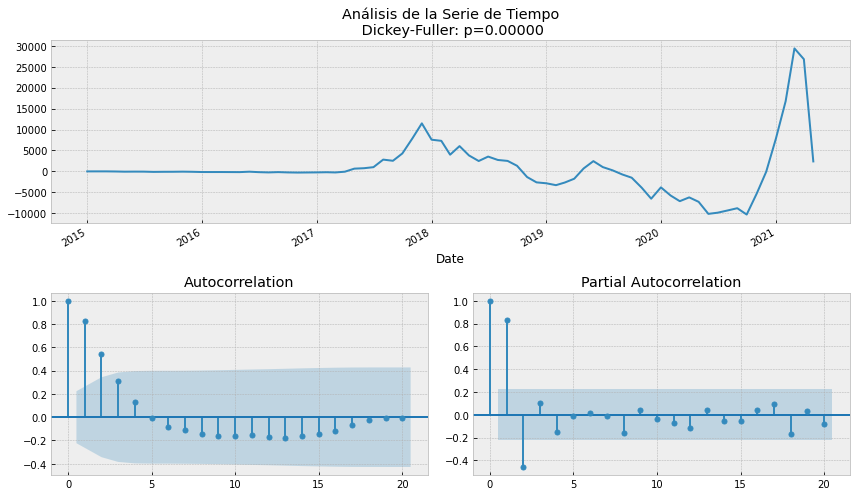

In [7]:
modelo = evaluacion("btc-usd","2015, 1, 1",6,20)

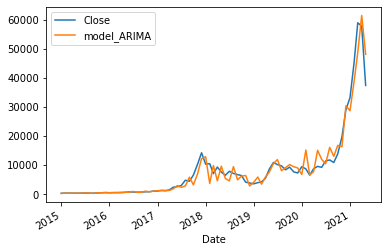

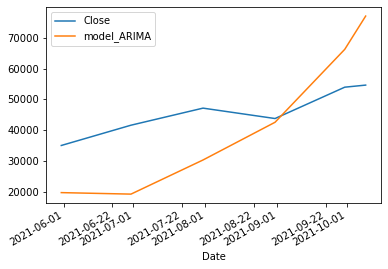

In [8]:
arima(modelo,2,0,2,0.05)

#para abajo es codigo repetido o que no utilicé arriba!

In [9]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
df = web.get_data_yahoo("ko", start, end, interval="m")
df = df[["Close","Volume"]]

In [10]:
df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
df['log_value'] = np.log(df['Close'])
df["sqrt"] = np.sqrt(df["Close"])

df['month'] = [d.strftime('%b') for d in df.index]
#df["day"] = [d.strftime('%d') for d in df.index]
dummies_mes = pd.get_dummies(df['month'],drop_first=True)
#dummies_dia = pd.get_dummies(df['day'],drop_first=True,prefix="day")
df = df.join(dummies_mes)
#df = df.join(dummies_dia)


In [11]:
df.tail()

,Close,Volume,timeIndex,log_value,sqrt,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,,,
2021-07-01,57.029999,293385300.0,138,4.043577,7.551821,Jul,0,0,0,0,1,0,0,0,0,0,0
2021-08-01,56.310001,220328500.0,139,4.030872,7.503999,Aug,1,0,0,0,0,0,0,0,0,0,0
2021-09-01,52.470001,334490400.0,140,3.960242,7.243618,Sep,0,0,0,0,0,0,0,0,0,0,1
2021-10-01,54.119999,101268800.0,141,3.991204,7.356630,Oct,0,0,0,0,0,0,0,0,0,1,0
2021-10-08,54.119999,13786820.0,142,3.991204,7.356630,Oct,0,0,0,0,0,0,0,0,0,1,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2010-01-01 to 2021-10-08
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      143 non-null    float64
 1   Volume     143 non-null    float64
 2   timeIndex  143 non-null    int32  
 3   log_value  143 non-null    float64
 4   sqrt       143 non-null    float64
 5   month      143 non-null    object 
 6   Aug        143 non-null    uint8  
 7   Dec        143 non-null    uint8  
 8   Feb        143 non-null    uint8  
 9   Jan        143 non-null    uint8  
 10  Jul        143 non-null    uint8  
 11  Jun        143 non-null    uint8  
 12  Mar        143 non-null    uint8  
 13  May        143 non-null    uint8  
 14  Nov        143 non-null    uint8  
 15  Oct        143 non-null    uint8  
 16  Sep        143 non-null    uint8  
dtypes: float64(4), int32(1), object(1), uint8(11)
memory usage: 12.9+ KB


In [13]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=6, random_state=42, shuffle=False)

In [14]:
model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()

In [15]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [16]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Resiudos del modelo

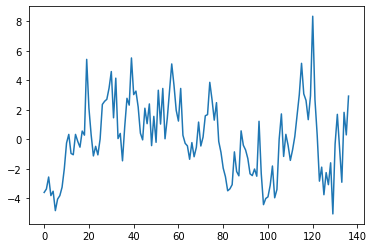

In [17]:
res_model = df_train['Close'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [18]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.819352
p-value: 0.002715
Valor crítico 1%: -3.48
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


Residuos del logaritmo

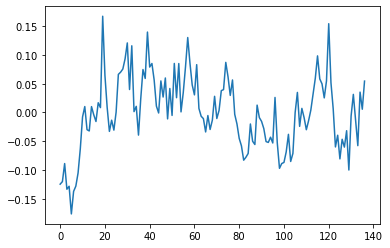

In [19]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [20]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -3.691358
p-value: 0.004236
Valor crítico 1%: -3.48
Valor crítico 5%: -2.88
Valor crítico 10%: -2.58


Residuos de la raiz cuadrada

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [22]:
lag_acf = acf(res_model, nlags = 20)
lag_acf

array([1.        , 0.68978572, 0.56968082, 0.41348733, 0.3653035 ,
       0.26213125, 0.21050179, 0.09966967, 0.09693621, 0.04059109,
       0.07288373, 0.08110731, 0.0517597 , 0.02900412, 0.0409497 ,
       0.06425161, 0.07039   , 0.07074449, 0.06380696, 0.09491663,
       0.05848019])

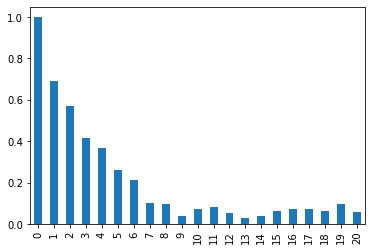

In [23]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [24]:
lag_pacf = pacf(res_model, nlags=20, method='ols');

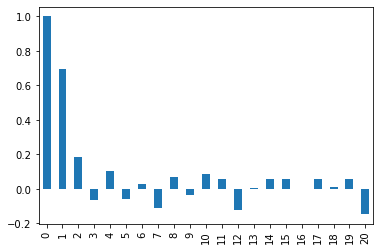

In [25]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [26]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

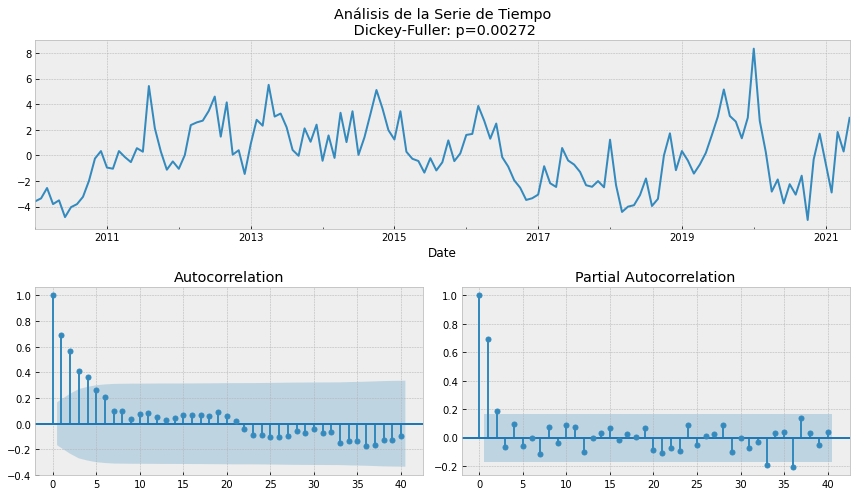

In [27]:
tsplot(res_model, lags=40)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
model_ARIMA = ARIMA(res_model, order=(2,0,4))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

Date
2010-01-01    0.028772
2010-02-01   -2.514140
2010-03-01   -2.584306
2010-04-01   -2.006634
2010-05-01   -2.707064
dtype: float64

In [30]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  137
Model:                     ARMA(2, 4)   Log Likelihood                -271.876
Method:                       css-mle   S.D. of innovations              1.755
Date:                Sat, 09 Oct 2021   AIC                            559.752
Time:                        18:14:28   BIC                            583.112
Sample:                    01-01-2010   HQIC                           569.245
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0288      0.604      0.048      0.962      -1.155       1.212
ar.L1.y       -0.0704      0.153     -0.461      0.645      -0.370       0.229
ar.L2.y        0.6904      0.144      4.793      0.0

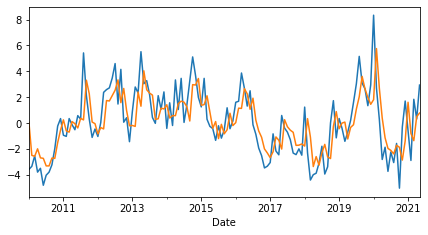

In [31]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

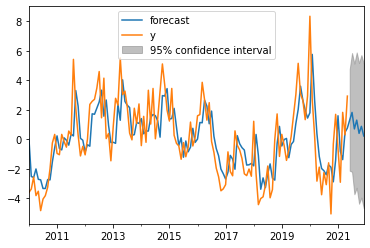

In [32]:
results_ARIMA.plot_predict(end=len(df['Close']));

In [33]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

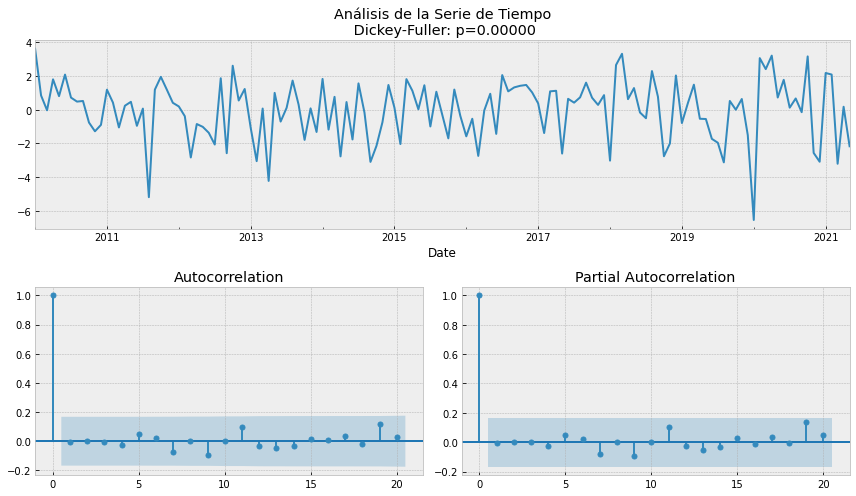

In [34]:
tsplot(res_ARIMA, lags=20)

In [35]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Close']), alpha=0.05)

In [36]:
df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues

correccion = + df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]

df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA


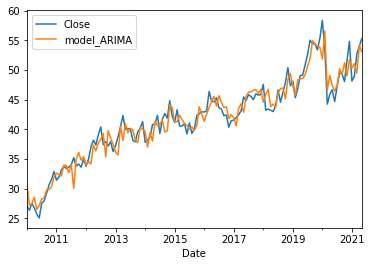

In [37]:
df_train.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [38]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [39]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Model + est + ARIMA"
df_Results.loc[0, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['Close'])
df_Results

,Model,RMSE
0,Model + est + ARIMA,4.80842


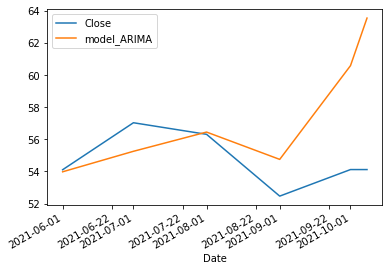

In [40]:
df_test.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [41]:
df_test

,Close,Volume,timeIndex,log_value,sqrt,month,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,model_log_est,back_model_log_est,model_ARIMA
Date,,,,,,,,,,,,,,,,,,,,
2021-06-01,54.110001,305857700.0,137,3.991019,7.355950,Jun,0,0,0,0,0,1,0,0,0,0,0,3.963996,52.667347,53.981447
2021-07-01,57.029999,293385300.0,138,4.043577,7.551821,Jul,0,0,0,0,1,0,0,0,0,0,0,3.978346,53.428597,55.255060
2021-08-01,56.310001,220328500.0,139,4.030872,7.503999,Aug,1,0,0,0,0,0,0,0,0,0,0,4.020764,55.743665,56.450125
2021-09-01,52.470001,334490400.0,140,3.960242,7.243618,Sep,0,0,0,0,0,0,0,0,0,0,1,3.978717,53.448400,54.752282
2021-10-01,54.119999,101268800.0,141,3.991204,7.356630,Oct,0,0,0,0,0,0,0,0,0,1,0,4.097182,60.170506,60.577360
2021-10-08,54.119999,13786820.0,142,3.991204,7.356630,Oct,0,0,0,0,0,0,0,0,0,1,0,4.137596,62.652035,63.534484


In [42]:
df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]

2.1677380043645584